In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats, special, integrate

 - https://en.wikipedia.org/wiki/Logit-normal_distribution
 - https://en.wikipedia.org/wiki/Logistic_function
 - https://en.wikipedia.org/wiki/Logit
 
 - https://github.com/scipy/scipy/blob/v1.8.1/scipy/stats/_continuous_distns.py#L5365-L5499
 
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html?highlight=rv_continous
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logit.html
 
 - https://github.com/statsmodels/statsmodels/blob/main/statsmodels/sandbox/distributions/transformed.py#L55
 - https://github.com/scipy/scipy/issues/12133
 
 - https://stackoverflow.com/questions/60669256/how-do-you-create-a-logit-normal-distribution-in-python
 
![Example](https://upload.wikimedia.org/wikipedia/commons/a/ae/LogitnormDensityGrid.svg)
 

In [5]:
class logitnorm_gen(stats.rv_continuous):

    def _argcheck(self, m, s):
        return (s > 0.) & (m > -np.inf)
    
    def _pdf(self, x, m, s):
        return stats.norm(loc=m, scale=s).pdf(special.logit(x))/(x*(1-x))
    
    def _cdf(self, x, m, s):
        return stats.norm(loc=m, scale=s).cdf(special.logit(x))
    
    def _rvs(self, m, s, size=None, random_state=None):
        return special.expit(m + s*random_state.standard_normal(size))
    
    def fit(self, data, **kwargs):
        return stats.norm.fit(special.logit(data), **kwargs)

logitnorm = logitnorm_gen(a=0.0, b=1.0, name="logitnorm")

In [6]:
logitnorm.fit([0.1, 0.2])

(-1.791759469228055, 0.4054651081081643)

In [7]:
def generate_fixtures(
    locs=[-2.0, -1.0, 0.0, 0.5, 1.0, 2.0],
    scales=[0.32, 0.56, 1.00, 1.78, 3.16],
    sizes=[1000], #sizes=[100, 1000, 10000],
    seeds=[789], #seeds=[789, 123456, 999999]
):
    for (loc, scale, size, seed) in itertools.product(locs, scales, sizes, seeds):
        yield {"parameters": {"loc": loc, "scale": scale}, "size": size, "random_state": seed}

{'loc': -2.0, 'scale': 0.32} {'size': 1000, 'random_state': 789}
Same: True
Unitary: 1.000000
Fit Parameters: (-1.9936041564396818, 0.32602355610316325)
KS Test: KstestResult(statistic=0.015432248713935483, pvalue=0.9681592607052483)
Chi2 Test: Power_divergenceResult(statistic=1.0273285280195663, pvalue=0.9943755603430806)
--------------------------------------------------------------------------------
{'loc': -2.0, 'scale': 0.56} {'size': 1000, 'random_state': 789}
Same: True
Unitary: 1.000000
Fit Parameters: (-1.9888072737694433, 0.5705412231805357)
KS Test: KstestResult(statistic=0.015432248713935483, pvalue=0.9681592607052483)
Chi2 Test: Power_divergenceResult(statistic=0.9993776535164721, pvalue=0.994838569578194)
--------------------------------------------------------------------------------
{'loc': -2.0, 'scale': 1.0} {'size': 1000, 'random_state': 789}
Same: True
Unitary: 1.000000
Fit Parameters: (-1.9800129888740057, 1.018823612822385)
KS Test: KstestResult(statistic=0.015432

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


{'loc': 1.0, 'scale': 1.0} {'size': 1000, 'random_state': 789}
Same: True
Unitary: 1.000000
Fit Parameters: (1.0199870111259943, 1.018823612822385)
KS Test: KstestResult(statistic=0.015432248713935504, pvalue=0.9681592607052478)
Chi2 Test: Power_divergenceResult(statistic=0.8757481598523852, pvalue=0.9965919007991503)
--------------------------------------------------------------------------------
{'loc': 1.0, 'scale': 1.78} {'size': 1000, 'random_state': 789}
Same: True
Unitary: 1.000000
Fit Parameters: (1.0355768798042697, 1.8135060308238449)
KS Test: KstestResult(statistic=0.015432248713935594, pvalue=0.9681592607052462)
Chi2 Test: Power_divergenceResult(statistic=0.6614133960948727, pvalue=0.9986149704324356)
--------------------------------------------------------------------------------
{'loc': 1.0, 'scale': 3.16} {'size': 1000, 'random_state': 789}
Same: True
Unitary: 0.997423
Fit Parameters: (1.0631589551581573, 3.2194826165187953)
KS Test: KstestResult(statistic=0.015432248713

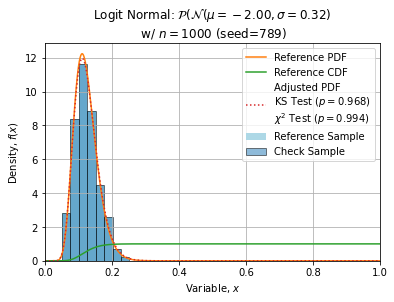

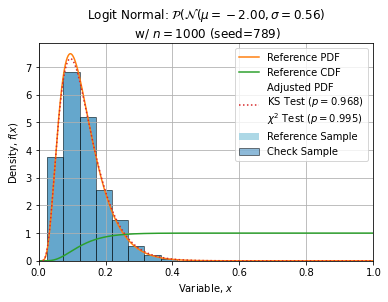

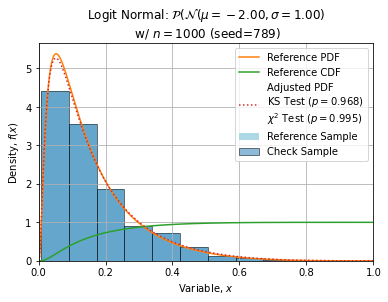

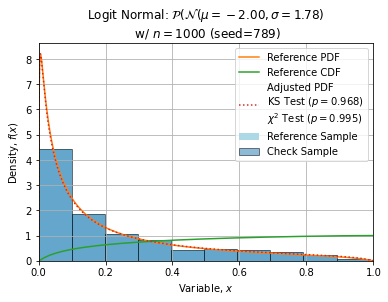

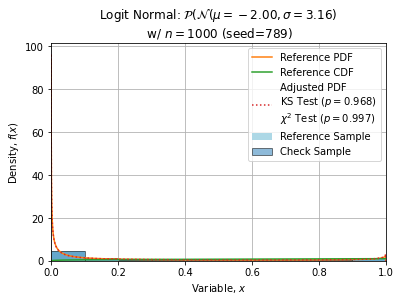

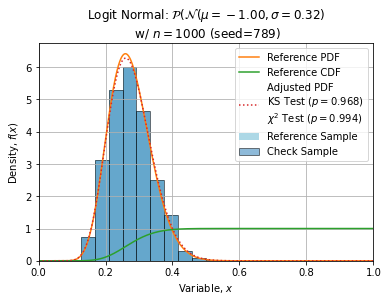

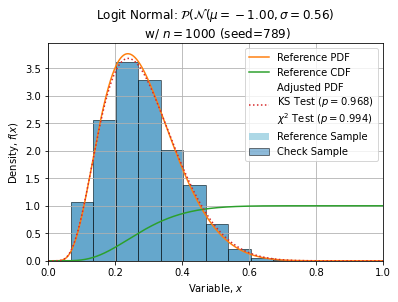

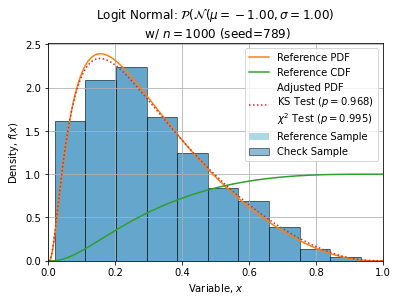

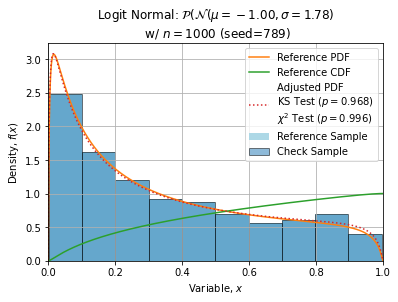

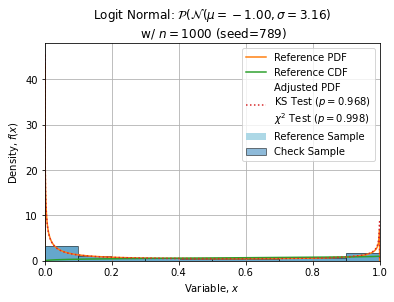

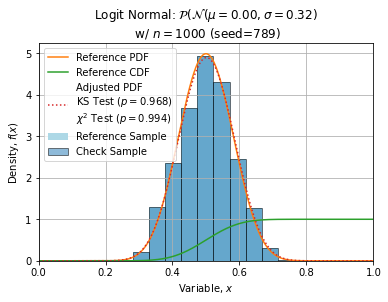

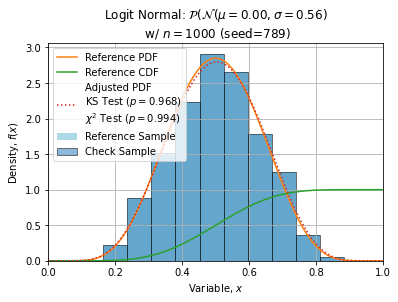

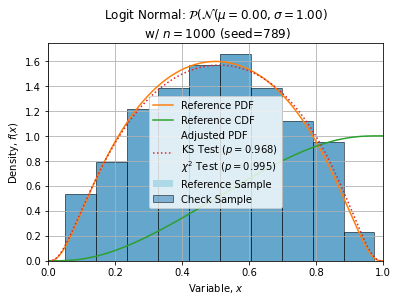

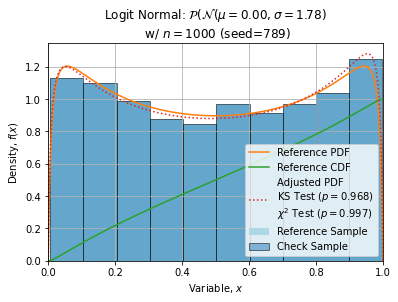

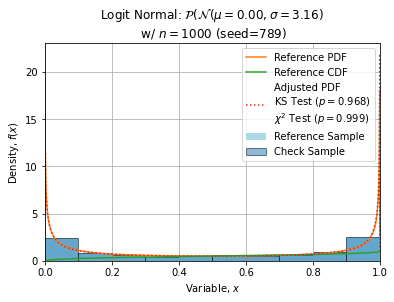

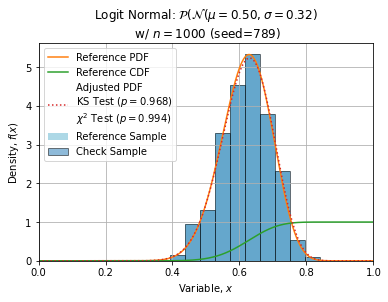

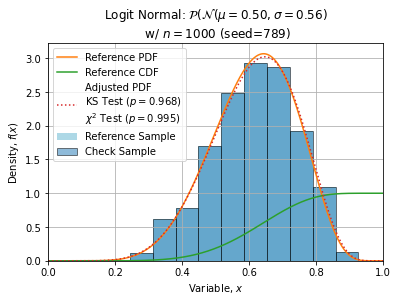

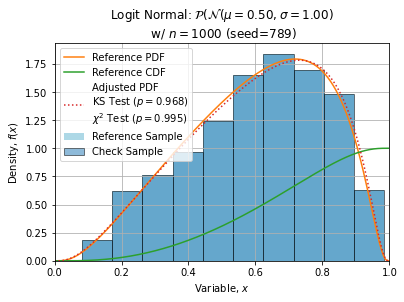

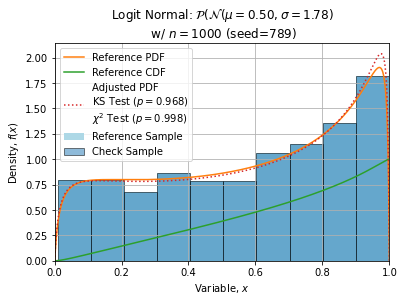

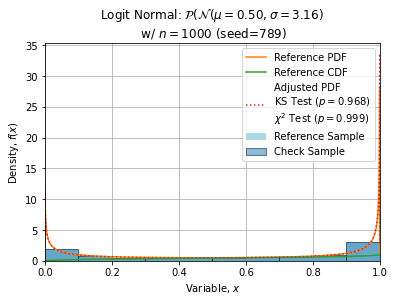

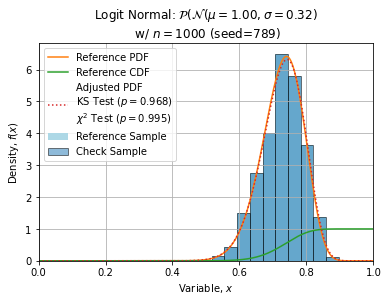

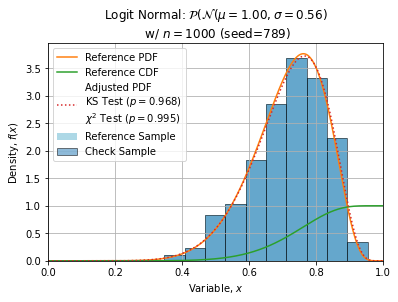

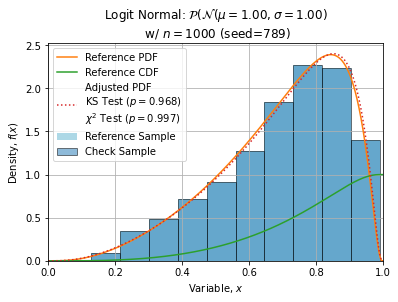

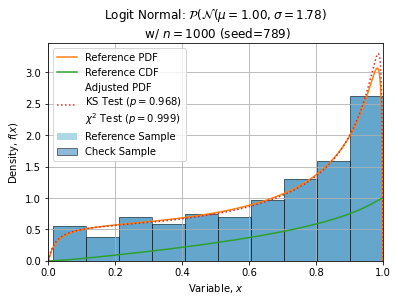

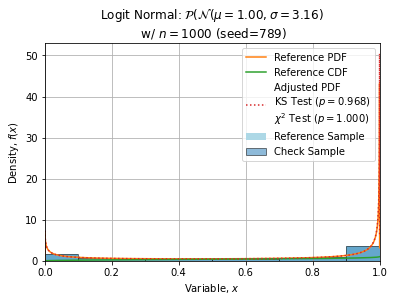

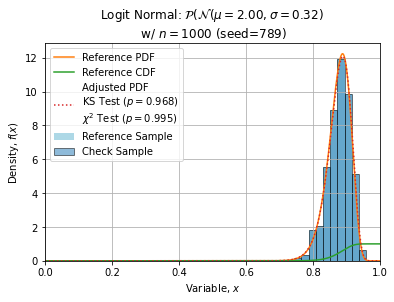

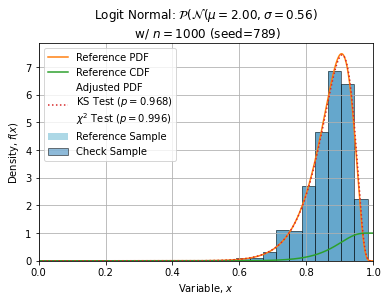

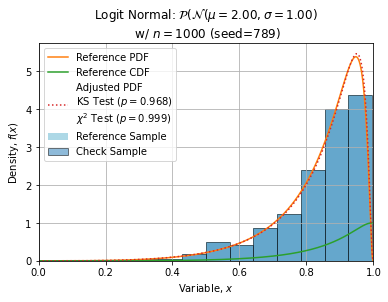

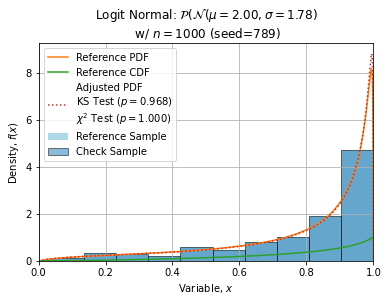

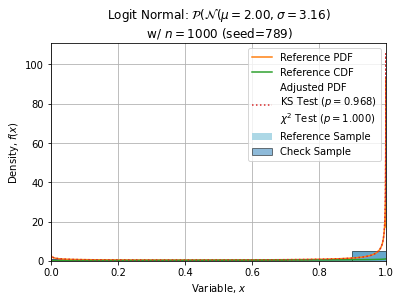

In [4]:
eps = 1e-8
x = np.linspace(0. + eps, 1. - eps, 10000)

for fixture in generate_fixtures():
    
    # Reference:
    parameters = fixture.pop("parameters")
    normal = stats.norm(**parameters)
    sample = special.expit(normal.rvs(**fixture))
    
    # Logit Normal Law:
    law = logitnorm(m=parameters["loc"], s=parameters["scale"])
    check = law.rvs(**fixture)
    
    # Fit:
    p = logitnorm.fit(sample)
    trial = logitnorm(*p)
    resample = trial.rvs(**fixture)
    
    # Hypothetis Tests:
    ks = stats.kstest(check, trial.cdf)
    bins = np.histogram(resample)[1]
    obs = np.diff(trial.cdf(bins))*fixture["size"]
    ref = np.diff(law.cdf(bins))*fixture["size"]
    chi2 = stats.chisquare(obs, ref, ddof=2)
    
    print(parameters, fixture)
    print("Same: %s" % np.allclose(sample - check, 0.0))
    print("Unitary: %f" % integrate.trapz(law.pdf(x), x=x))
    print("Fit Parameters: %s" % (p,))
    print("KS Test: %s" % (ks,))
    print("Chi2 Test: %s" % (chi2,))
    #print("Reference: %s" % ref)
    #print("Observed: %s" % obs)
    print("-"*80)
    
    # Show:
    if True:
        fig, axe = plt.subplots()
        axe.hist(sample, density=1, color="lightblue", label="Reference Sample")
        axe.hist(check, density=1, alpha=0.5, edgecolor="black", label="Check Sample")
        axe.plot(x, law.pdf(x), label="Reference PDF")
        axe.plot(x, law.cdf(x), label="Reference CDF")
        axe.plot(x, trial.pdf(x), ":", label="Adjusted PDF\nKS Test ($p = {:.3f}$)\n$\chi^2$ Test ($p = {:.3f}$)".format(ks.pvalue, chi2.pvalue))
        axe.set_title("Logit Normal: $\mathcal{{P}}(\mathcal{{N}}(\mu={loc:.2f}, \sigma={scale:.2f})$\n w/ $n={size:}$ (seed={random_state:})".format(**fixture, **parameters))
        axe.set_xlabel("Variable, $x$")
        axe.set_ylabel("Density, $f(x)$")
        axe.set_xlim([0, 1])
        axe.legend()
        axe.grid()